In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box 
from shapely.geometry import Point
import pandas as pd
import glob
import os
import leafmap.foliumap as leafmap

In [15]:
# =============== Paths ===============
DATA_DIR = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Data"
RGB_DIR = os.path.join(DATA_DIR, "rgb")
SHAPEFILE = os.path.join(DATA_DIR, "delhi_ncr_region.geojson")
PLOT_DIR = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Scripts/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

In [16]:
# =============== Load NCR shapefile ===============
ncr = gpd.read_file(SHAPEFILE).to_crs(epsg=32644)

In [19]:
# Create grid
xmin, ymin, xmax, ymax = ncr.total_bounds
grid_size = 60000  # 60 km in meters
cols = list(range(int(xmin), int(xmax), grid_size))
rows = list(range(int(ymin), int(ymax), grid_size))
polygons = []
centers = []
corners = []
for x in cols:
    for y in rows:
        poly = box(x, y, x+grid_size, y+grid_size)
        polygons.append(poly)
        minx, miny, maxx, maxy = poly.bounds
        cx, cy = poly.centroid.x, poly.centroid.y
        centers.append(Point(cx, cy))
        corners.extend([
            Point(minx, miny), Point(minx, maxy), 
            Point(maxx, miny), Point(maxx, maxy)
        ])

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=ncr.crs)
center_points = gpd.GeoDataFrame(geometry=centers, crs=ncr.crs)
corner_points = gpd.GeoDataFrame(geometry=corners, crs=ncr.crs)

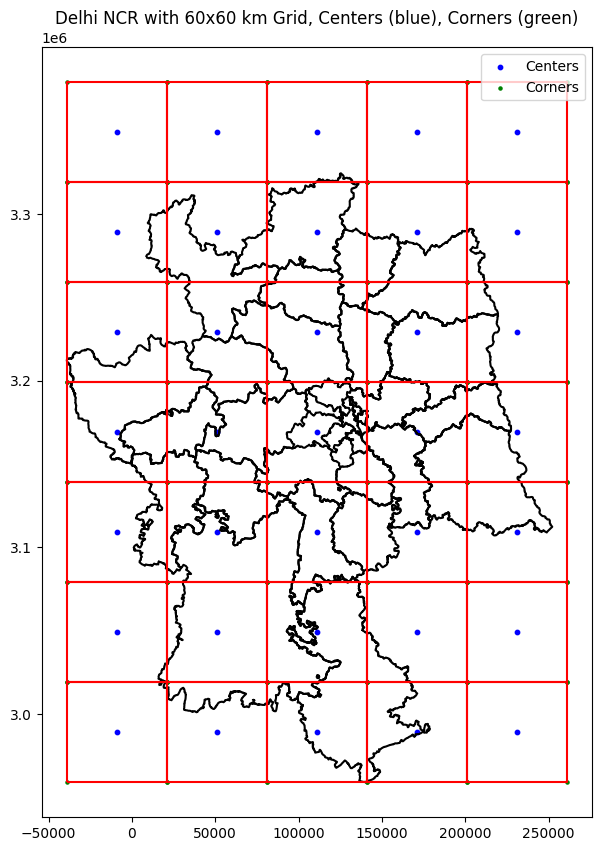

Matplotlib plot saved to: C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Scripts/plots/grid_with_centers_corners.png


In [25]:
# Plot with corners & center
fig, ax = plt.subplots(figsize=(10,10))
ncr.boundary.plot(ax=ax, edgecolor='black')
grid.boundary.plot(ax=ax, color='red')
center_points.plot(ax=ax, color='blue', markersize=10, label='Centers')
corner_points.plot(ax=ax, color='green', markersize=5, label='Corners')
plt.legend()
plt.title("Delhi NCR with 60x60 km Grid, Centers (blue), Corners (green)")
plt.show()
plt.savefig(os.path.join(PLOT_DIR, "grid_with_centers_corners.png"))
plt.close()

print(f"Matplotlib plot saved to: {PLOT_DIR}/grid_with_centers_corners.png")

In [27]:
from IPython.display import display

In [28]:
# Leafmap plot
m = leafmap.Map(center=[28.61, 77.23], zoom=8)
m.add_gdf(ncr, style={"color": "black", "fillOpacity": 0}, layer_name="NCR")
m.add_gdf(grid, style={"color": "red", "fillOpacity": 0}, layer_name="Grid")
m.add_gdf(center_points, style={"color": "blue"}, layer_name="Centers")
m.add_gdf(corner_points, style={"color": "green"}, layer_name="Corners")
m.add_basemap("SATELLITE")
display(m)
m.to_html(os.path.join(PLOT_DIR, "grid_on_basemap.html"))
print(f"Leafmap plot saved to: {PLOT_DIR}/grid_on_basemap.html")

Leafmap plot saved to: C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Scripts/plots/grid_on_basemap.html


In [22]:
# Filtering
image_files = glob.glob(os.path.join(RGB_DIR, "*.png"))
records = []
for f in image_files:
    fname = os.path.basename(f).replace(".png", "")
    parts = fname.split("_")
    try:
        lat = float(parts[0])
        lon = float(parts[1])
        records.append({"file": f, "lat": lat, "lon": lon})
    except Exception as e:
        print(f"Could not parse: {fname} — {e}")

df = pd.DataFrame(records)

gdf_imgs = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
).to_crs(epsg=32644)

before = len(gdf_imgs)

In [23]:
# Now we filter to those that fall inside required region
filtered_imgs = gdf_imgs[gdf_imgs.within(ncr.unary_union)]

after = len(filtered_imgs)

print(f"Number of images before filtering: {before}")
print(f"Number of images after filtering: {after}")

Number of images before filtering: 9216
Number of images after filtering: 8015


In [24]:
# Saving as csv for QUESTION 2
filtered_imgs[['file', 'lat', 'lon']].to_csv("../filtered_images.csv", index=False)
print("Filtered image list saved to: ../filtered_images.csv")

Filtered image list saved to: ../filtered_images.csv
